# Inverse distance weighting - Meuse Dataset

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [21]:
meuse_df = pd.read_csv("meuse_processed.csv")

In [22]:
display(meuse_df)

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460


## Splitting Data

In [23]:
# Convert columns to numpy arrays
observed_location_columns_meuse = ['x', 'y']
observed_values_column_meuse = 'zinc'
observed_locations_meuse = meuse_df[observed_location_columns_meuse].values
observed_values_meuse = meuse_df[observed_values_column_meuse].values

In [24]:
X_train_meuse, X_test_meuse, y_train_meuse, y_test_meuse = train_test_split(observed_locations_meuse,
                                                                            observed_values_meuse, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_meuse.shape}")
print(f"X_test_meuse.shape:  {X_test_meuse.shape}")
print(f"y_train_meuse.shape: {y_train_meuse.shape}")
print(f"y_test_meuse.shape:  {y_test_meuse.shape}")

X_train_meuse.shape: (124, 2)
X_test_meuse.shape:  (31, 2)
y_train_meuse.shape: (124,)
y_test_meuse.shape:  (31,)


## K-Fold Cross Validation

In [25]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]

In [26]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

#For each possible theoratical model, conduct K-Fold CV
for i, power in enumerate((1,2,3,4,5,6)):
    
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = power)
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[power] = {
        "CV Score MAE" : mean_validation_score_mae,
        "CV Score RMSE" : mean_validation_score_rmse,
        "CV Score MAPE" : mean_validation_score_mape,
        "CV Score R Squared" : mean_validation_score_r2
    }

# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric
# Initialize a dictionary to track the smallest scores and corresponding models
smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "power": None},
    "CV Score RMSE": {"value": float('inf'), "power": None},
    "CV Score MAPE": {"value": float('inf'), "power": None},
    "CV Score R Squared": {"value": float('inf'), "power": None}
}

# Iterate through each model's scores in the dictionary
for power, scores in cv_score_list.items():
    for score_type in scores:
        if scores[score_type] < smallest_scores[score_type]["value"]:
            smallest_scores[score_type]["value"] = scores[score_type]
            smallest_scores[score_type]["power"] = power

# Display the results
for score_type, info in smallest_scores.items():
    print(f"The smallest {score_type} is {info['value']}, found in power of {info['power']}.")

,1,2,3,4,5,6
CV Score MAE,0.408273,0.391944,0.391020,0.394876,0.398866,0.403726
CV Score RMSE,0.519785,0.504509,0.509097,0.520472,0.531599,0.541268
CV Score MAPE,0.068801,0.066370,0.066422,0.067148,0.067847,0.068643
CV Score R Squared,0.474342,0.504510,0.494646,0.470717,0.446684,0.425284


The smallest CV Score MAE is 0.3910199097798915, found in power of 3.
The smallest CV Score RMSE is 0.5045087606769496, found in power of 2.
The smallest CV Score MAPE is 0.06636973489007081, found in power of 2.
The smallest CV Score R Squared is 0.4252837121541761, found in power of 6.


### n_neighbors

In [27]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

# For each possible number of neighbors, conduct K-Fold CV
n_neighbors_list = [2, 4, 6, 8, 10, 12]
for n_neighbors in n_neighbors_list:
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, n_neighbors = n_neighbors)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calculate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    # Store the mean CV score for each metric for this iteration of n_neighbors chosen
    cv_score_list[n_neighbors] = {
        "CV Score MAE": mean_validation_score_mae,
        "CV Score RMSE": mean_validation_score_rmse,
        "CV Score MAPE": mean_validation_score_mape,
        "CV Score R Squared": mean_validation_score_r2
    }

# Display the results
display(pd.DataFrame(cv_score_list))  # Transposed for better readability

# Find the model with the smallest mean CV score for each metric
# Adjusted to find the best `n_neighbors`
smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "n_neighbors": None},
    "CV Score RMSE": {"value": float('inf'), "n_neighbors": None},
    "CV Score MAPE": {"value": float('inf'), "n_neighbors": None},
    "CV Score R Squared" : {"value": float('inf'), "n_neighbors": None}
}

for n_neighbors, scores in cv_score_list.items():
    for score_type in scores:
        if scores[score_type] < smallest_scores[score_type]["value"]:
            smallest_scores[score_type]["value"] = scores[score_type]
            smallest_scores[score_type]["n_neighbors"] = n_neighbors

# Display the results
for score_type, info in smallest_scores.items():
    print(f"The smallest {score_type} is {info['value']}, found with {info['n_neighbors']} neighbors.")


,2,4,6,8,10,12
CV Score MAE,0.412433,0.393280,0.401171,0.408273,0.424380,0.438341
CV Score RMSE,0.553308,0.513837,0.514640,0.519785,0.529702,0.533643
CV Score MAPE,0.070147,0.066568,0.067506,0.068801,0.071398,0.073968
CV Score R Squared,0.394802,0.490957,0.482743,0.474342,0.457185,0.449966


The smallest CV Score MAE is 0.39327983716324894, found with 4 neighbors.
The smallest CV Score RMSE is 0.5138365458671013, found with 4 neighbors.
The smallest CV Score MAPE is 0.06656814758509753, found with 4 neighbors.
The smallest CV Score R Squared is 0.39480167625040447, found with 2 neighbors.


## Hyperparameter selection

As we can see, power = 2 and n_neighbors = 4 would be the most optimal option.

## Evaluation of Model (Testing Chosen model)

Is it supposed to refit model on all the train data then test on test data?

### Performance Metrics of Model

In [29]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]

train_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

x_data_test = [inner_list[0] for inner_list in X_test_meuse]
y_data_test = [inner_list[1] for inner_list in X_test_meuse]

test_data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_meuse
})

eval_combined_array_coordinates = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, train_data['Z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 2, n_neighbors = 4)

rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_test))
mae = mean_absolute_error(test_data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(test_data['Z'], z_pred_test)
r2 = r2_score(test_data['Z'], z_pred_test)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)

MAE: 0.2581104538589278
RMSE: 0.36555290317584516
MAPE: 0.04531035418877555
R Squared: 0.6938253957800202


### Plotting Spatial Interpolation of entire area with Model

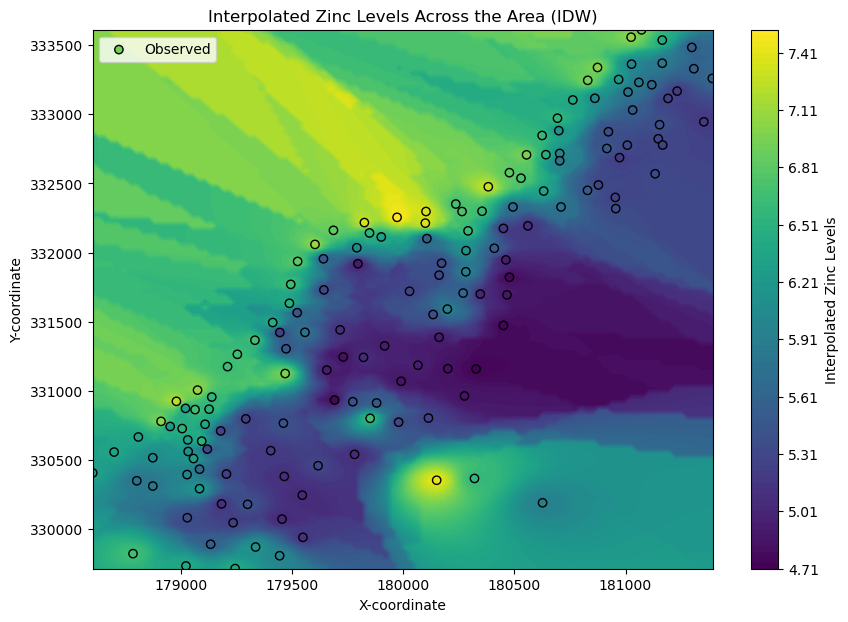

Spatial Interpolation Computation Time: 0.31 seconds


In [30]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 2, n_neighbors = 4)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

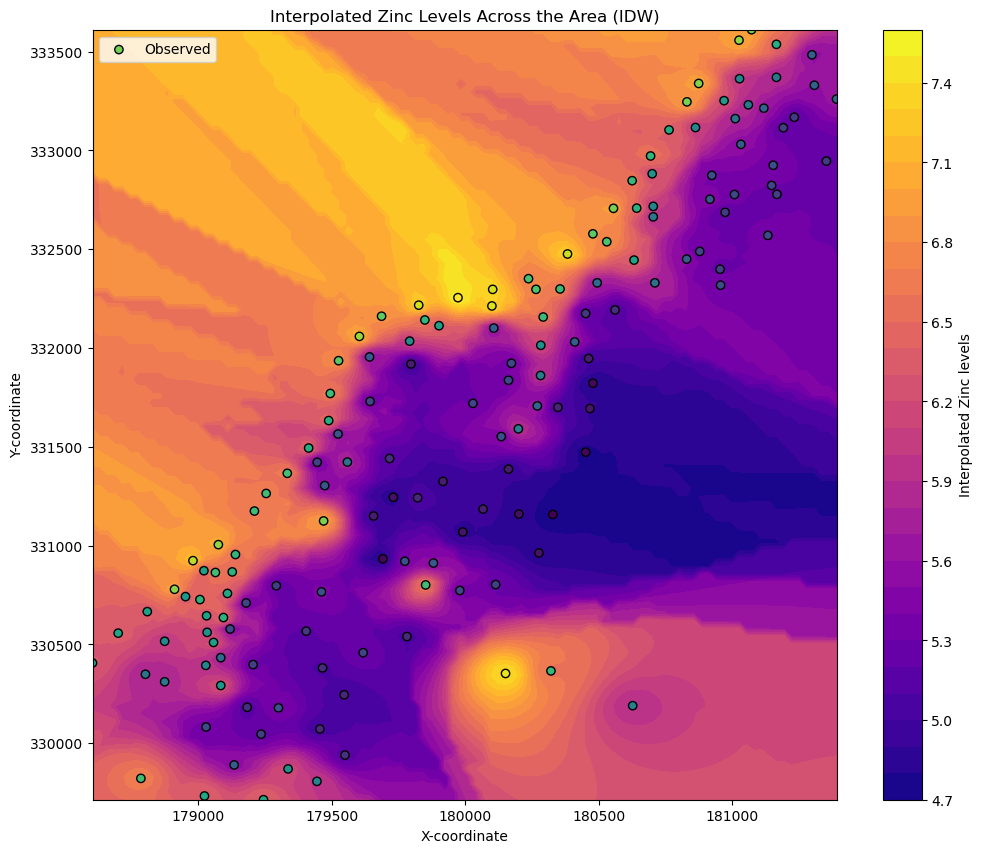

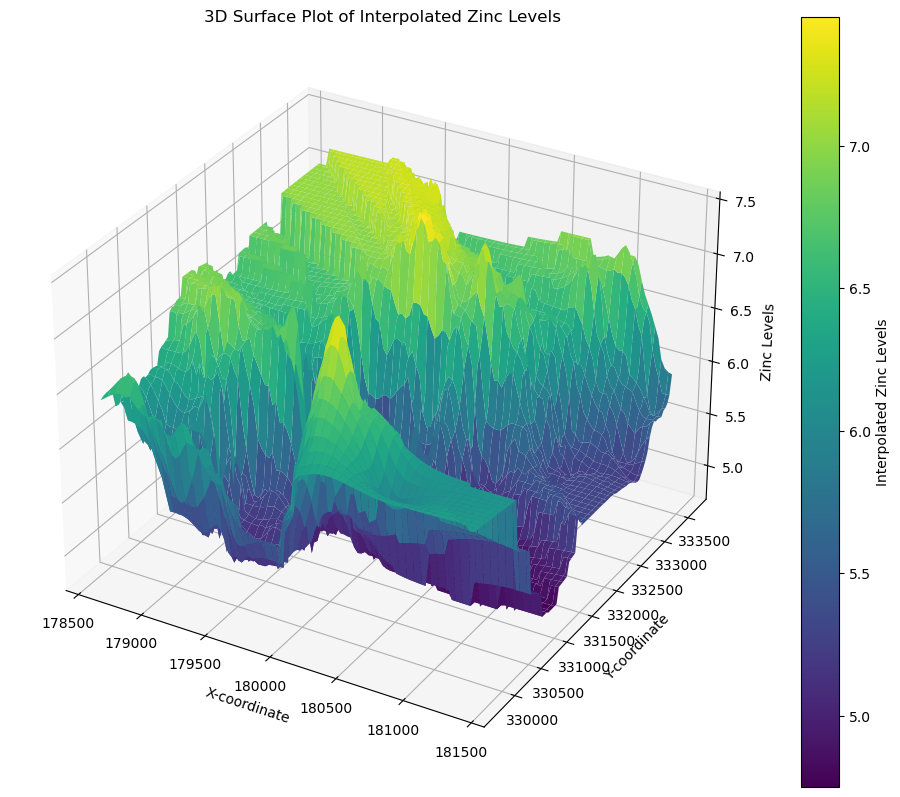

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


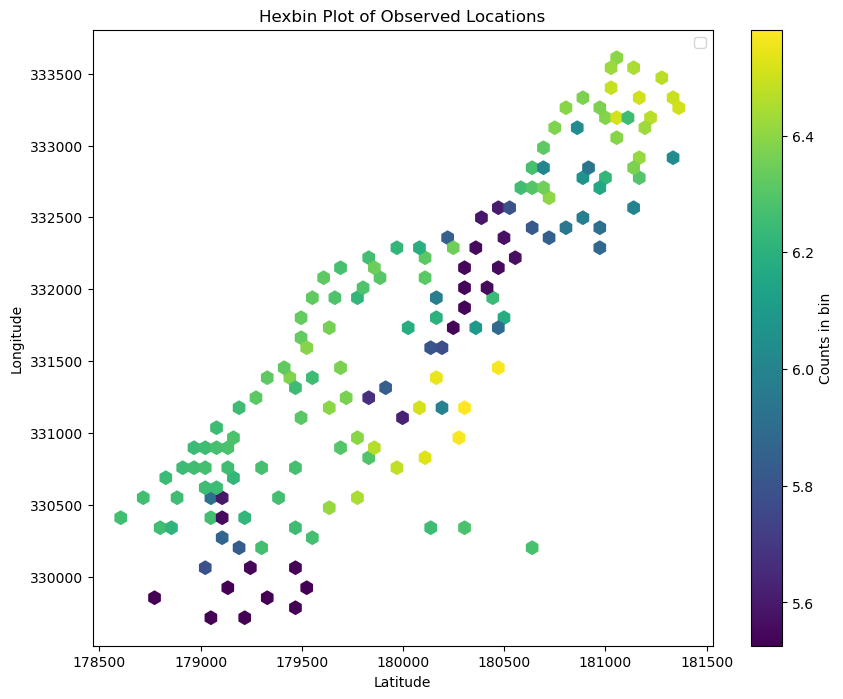

In [32]:
# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
y_min, y_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 2, n_neighbors = 4)
z_grid = interpolated_values.reshape(x_grid.shape)


fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated Zinc levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated Zinc Levels')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Zinc Levels')
ax.set_title('3D Surface Plot of Interpolated Zinc Levels')
plt.show()


plt.figure(figsize=(10, 8))
hb = plt.hexbin(meuse_df['x'], meuse_df['y'],C = interpolated_values, gridsize=50, cmap='viridis')
plt.colorbar(hb, label='Counts in bin')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.title('Hexbin Plot of Observed Locations')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time

# Assuming 'crimes_df' is your DataFrame containing the data

# Convert columns to numpy arrays
observed_location_columns = ['Latitude', 'Longitude']
observed_values_column = 'n'
observed_locations = crimes_df[observed_location_columns].values
observed_values = crimes_df[observed_values_column].values

# Number of nearest neighbors to consider
n_neighbors = 160

# Initialize NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Perform spatial interpolation over the entire dataset for visualization
nn_model.fit(observed_locations)  # Re-fit model using all data

# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
y_min, y_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Find nearest neighbors for the grid points
distances, indices = nn_model.kneighbors(grid_points)

# Interpolate values
interpolated_values = np.mean(observed_values[indices], axis=1)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(12, 10))  # Adjusted figure size for standard display
plt.contour(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated n values')
plt.scatter(crimes_df['Latitude'],crimes_df['Longitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s=30, alpha=0.8)

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.figure(figsize=(10, 8))
hb = plt.hexbin(crimes_df['Longitude'], crimes_df['Latitude'], gridsize=50, cmap='viridis')
plt.colorbar(hb, label='Counts in bin')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.title('Hexbin Plot of Observed Locations')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")